### Decision Tree classifier

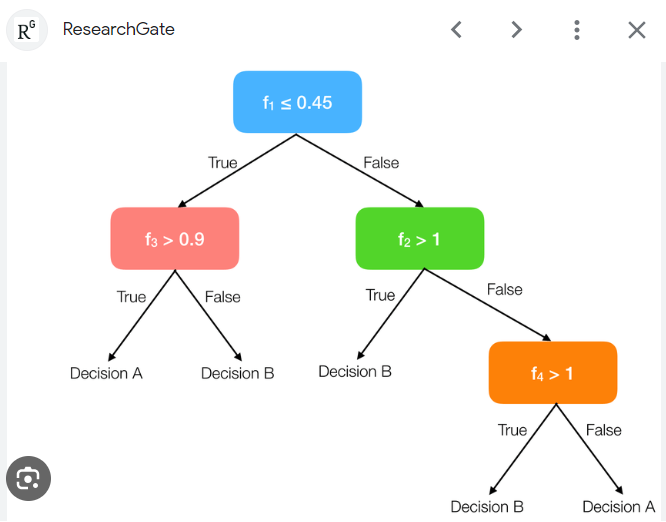

- És un model de classificació supervisat. 
- En cada node, tenim una mesura de impuresa (com de barreja de classe tenim en aquell node)
- Quan anem dividint, al final arribem a un node pur. (només hi ha observacions de la mateixa classe)
- Donat que tenim varis atributs, fa una divisio de l'espai de cada un dels atributs. 
- Podem donar una descripció semantica (el perque) el que es el que fa que estiguin aqui:
    - Tenen aquest atribut menor x, l'altre en el rang x
    - Tots els que tenen el punt de split a l'esquerre . Acabaran a la esquerre del tot. 
- Parlem d'arbres binaris
- 
- De 20_000 cap amunt a una costat del arbre i cap avall cap a l'altre costat de l'arbre. 
- Notebook anterior. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [3]:
df = pd.read_excel('./Dry_Bean_Dataset.xlsx')
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [4]:
np.any(df.isna())

False

In [5]:
df['target'] = pd.factorize(df.Class)[0]

- Factoritzem perque el decision tree necesita classes numeriques. Classes de la classificació.
- Si fossin atributs discrets, ho hauríem de mirar.

In [6]:
df.groupby('Class').target.value_counts()

Class     target
BARBUNYA  1         1322
BOMBAY    2          522
CALI      3         1630
DERMASON  6         3546
HOROZ     4         1928
SEKER     0         2027
SIRA      5         2636
Name: count, dtype: int64

- Treu la classe original més la target i li diu target com a y

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df[df.columns[:-2]], df['target'], test_size = 0.2, random_state = 2983)

In [8]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

### `min_samples_leaf`
- l'arbre l'anem expandint fins a un node que ja no s'expandeix més. L'anem exapndint fins que a cada fulla/node és un node pur. 
- això a vegades donen arbres molt grans. Si volem que siguin tots purs, serà un overfitting molt gran. Amb un node/fulla queda un sol element. (màxim overfitting que podem generar). 
- Arbre bo, troba cada classe en quin interval ha d'estar per ser de una classe. Dona una informació semantica.
- Pero el problema es que si el deixem que es vagi expandint, fa overfitting. haurem d'anar fent definicions que ja no són definicions de classe sinó de cada element. 
- hem de trobar la manera de parar-ho. 
- Hi ha bastantes maneres de parar-ho. La més fàcil és: fixar el nombre mínim de observacions en una fulla. Si arribem en algun lloc que no és pur però amb 5 mostres, ja no baixem més.
- 0.05 => 5% del total. 

In [9]:
min_samples_leaf = 0.05
ytrain.count(), np.ceil(ytrain.count() *min_samples_leaf)

(10888, 545.0)

- Si hi han menys de 545 mostres en un node no dividirem més.
- Per fer això hem de tenir en compte quantes n'hi ha de cada. de bombay 522. 
- Al final veurem que el bombay apareix en més de 1 node, etc, etc. 

In [10]:
dtc = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = min_samples_leaf)

In [11]:
dtc.fit(Xtrain, ytrain)

DecisionTreeClassifier(min_samples_leaf=0.05)

In [12]:
yhard = dtc.predict(Xtest)

In [13]:
# tree score: mean accuracy on test set
dtc.score(Xtest, ytest)

0.8494307748806463

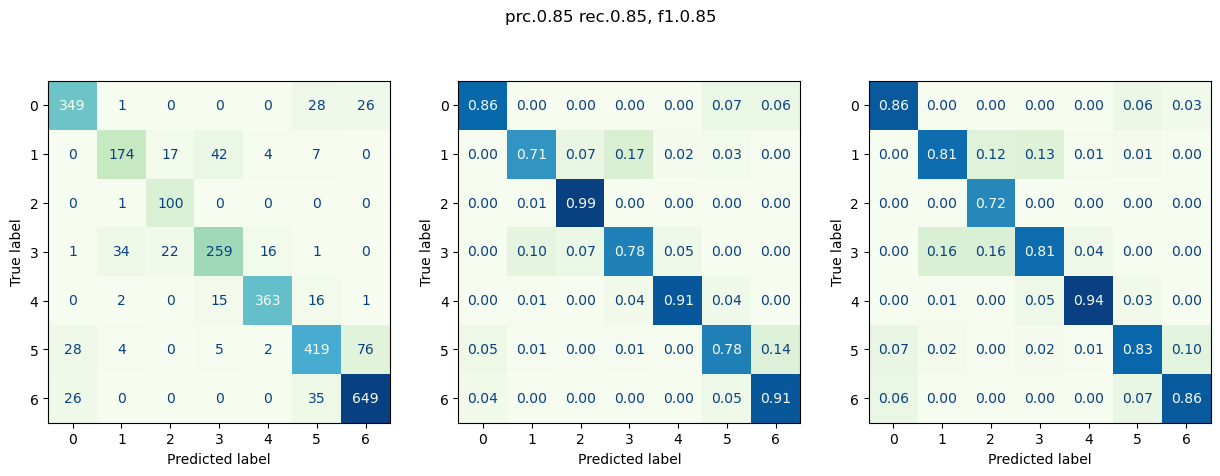

In [14]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
for norm, axi in zip([None, 'true', 'pred'], axs):
    ConfusionMatrixDisplay.from_predictions(
        ytest,
        yhard,
        normalize = norm,
        ax = axi,
        values_format = '.2f' if norm is not None else '.0f',
        cmap = 'GnBu',
        colorbar = False
    )
prc, rec, f1, _ = precision_recall_fscore_support(ytest, yhard, average = 'weighted')
plt.suptitle('prc.%4.2f rec.%4.2f, f1.%4.2f' %(prc, rec, f1));

In [15]:
ysoft = dtc.predict_proba(Xtest)

In [16]:
output = pd.concat((ytest.reset_index(), pd.DataFrame(ysoft, columns = df.Class.unique()), pd.Series(yhard)), axis = 1)
output

,index,target,SEKER,BARBUNYA,BOMBAY,CALI,HOROZ,SIRA,DERMASON,0
0,492,0,0.611009,0.005505,0.000000,0.000000,0.001835,0.218349,0.163303,0
1,6537,4,0.000000,0.007299,0.012774,0.166058,0.802920,0.009124,0.001825,4
2,3363,2,0.000000,0.121101,0.757798,0.121101,0.000000,0.000000,0.000000,2
3,1155,0,0.985321,0.003670,0.000000,0.000000,0.000000,0.000000,0.011009,0
4,6235,4,0.000000,0.007299,0.012774,0.166058,0.802920,0.009124,0.001825,4
...,...,...,...,...,...,...,...,...,...,...
2718,11612,6,0.110092,0.000000,0.000000,0.000000,0.001835,0.044037,0.844037,6
2719,5601,4,0.000000,0.000000,0.000000,0.001085,0.998915,0.000000,0.000000,4
2720,12685,6,0.000000,0.000000,0.000000,0.000000,0.011009,0.027523,0.961468,6
2721,4791,3,0.000000,0.052696,0.000000,0.925245,0.015931,0.006127,0.000000,3


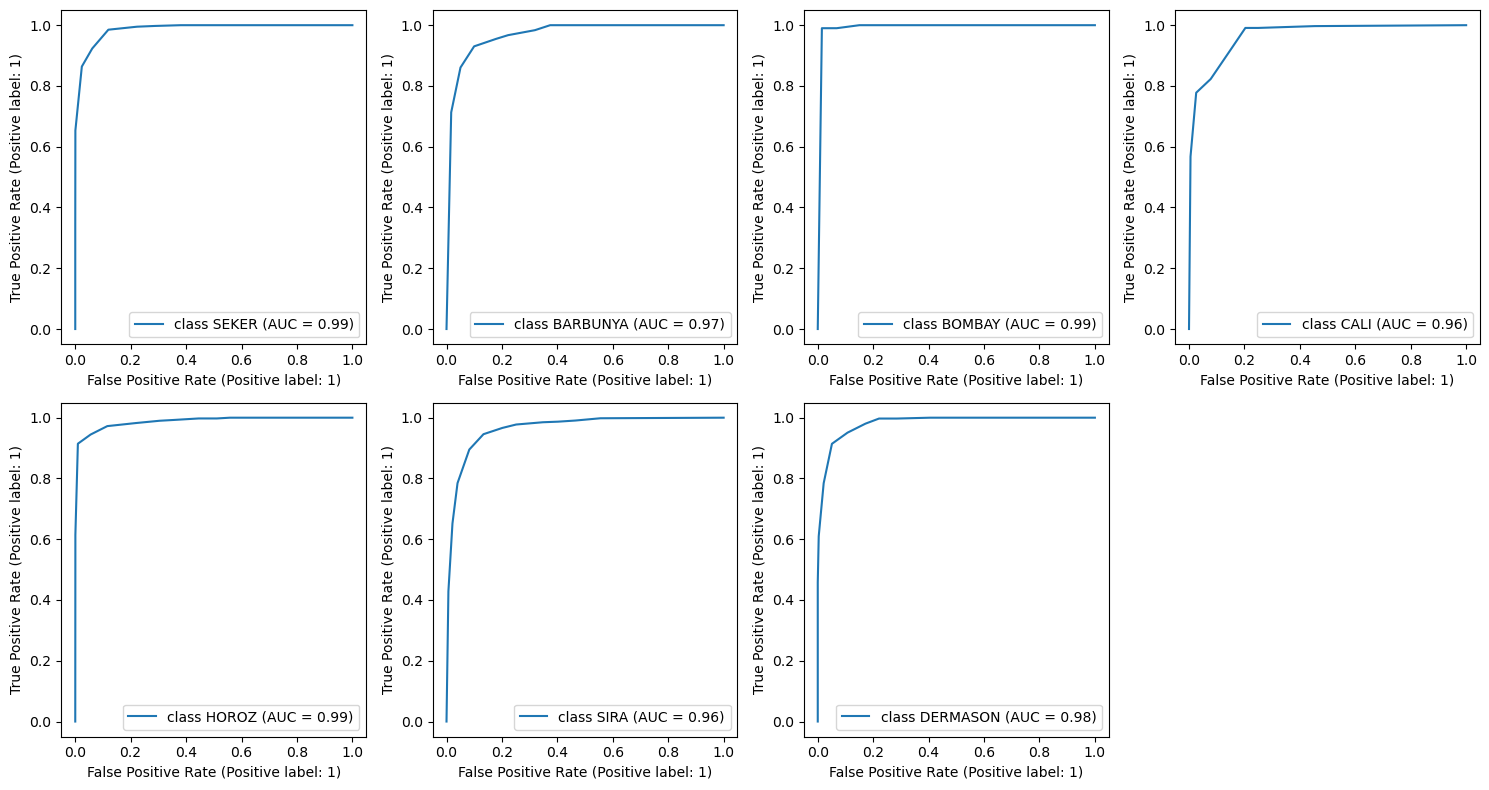

In [17]:
fig, axs = plt.subplots(2, 4, figsize = (15, 8))
for trgt, className in enumerate(df.Class.unique()):
    RocCurveDisplay.from_predictions(
        [int(y == trgt) for y in ytest],
        ysoft[:, trgt],
        name = f"class {className}",
        ax = axs.flatten()[trgt]
    )
axs.flatten()[-1].axis('off')
plt.tight_layout()

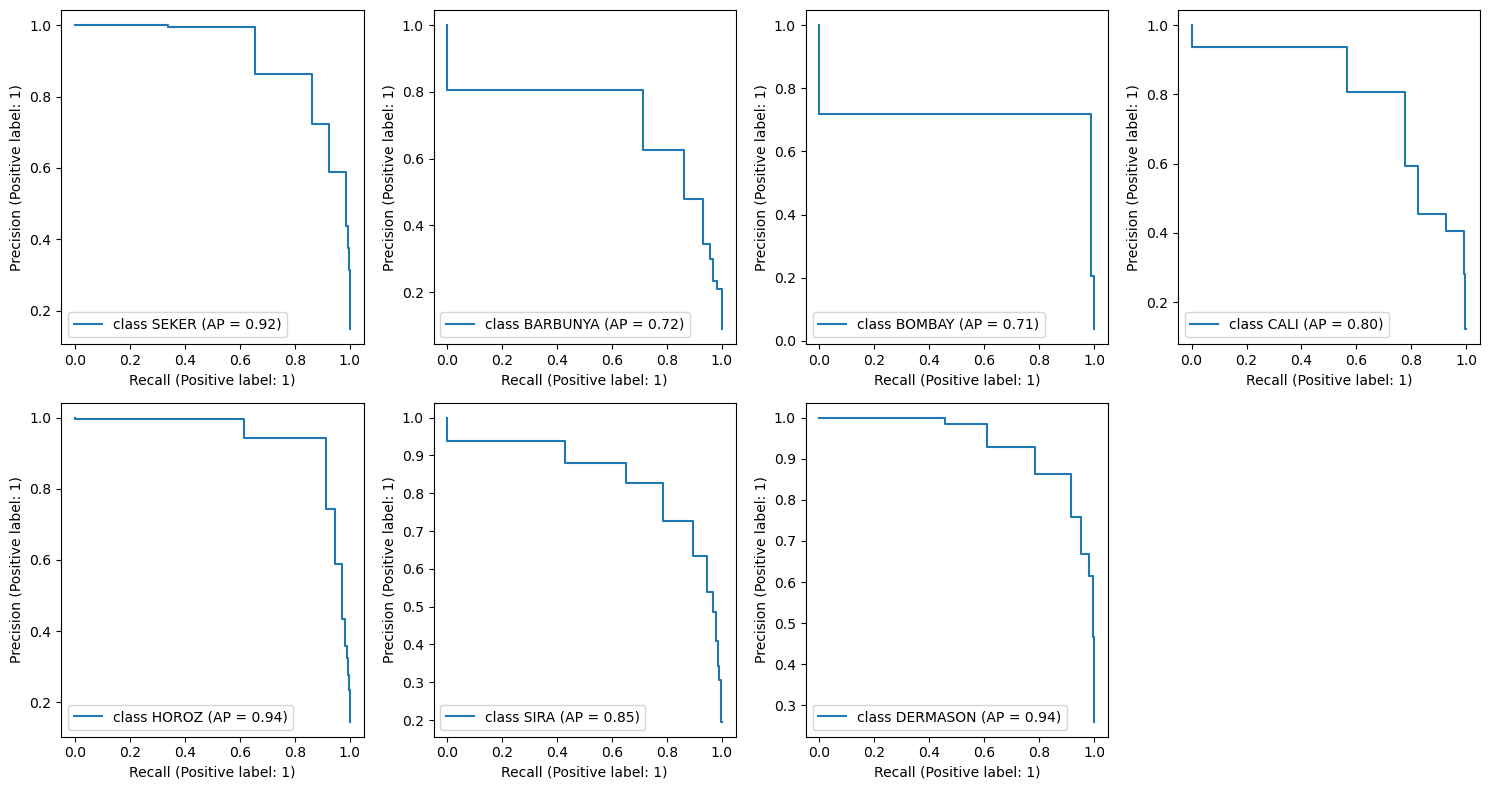

In [18]:
fig, axs = plt.subplots(2, 4, figsize = (15, 8))
for trgt, className in enumerate(df.Class.unique()):
    PrecisionRecallDisplay.from_predictions(
        [int(y == trgt) for y in ytest],
        ysoft[:, trgt],
        name = f"class {className}",
        ax = axs.flatten()[trgt]
    )
axs.flatten()[-1].axis('off')
plt.tight_layout()

- presicion
- mirem la presicio vs el recall, que serveix pel mateix, si volem un model de molta presició, ens hauríem de quedar per la zona alta de les curves.
- en el 3 podem tenir una presició del 70% amb un recall molt gran. 
- si volem un gran recall haurem de sacrificar presició.
- equilibri entre els que volem classificar i com de presicos hem de ser. 
- roc curve més de sicencia
- presicon recall més de datascience.
- serveixen pel mateix, definir threashold, a partir de quant te la creus la predicció. 

##### text representation of the  tree
- Definició semantica (en aquest node tenim, classe: 0, les barbuña, tenen atribut 2 <= 2812 atribut 12 
- Tenim dos barbuñas
- Hauríem de podar l'arbre. 
- Sempre intenta fer la partició que li dona menys impuresa. Punt de tall que li separa millor.

In [19]:
print(tree.export_text(dtc))

|--- feature_2 <= 280.70
|   |--- feature_12 <= 0.01
|   |   |--- feature_14 <= 0.78
|   |   |   |--- class: 0
|   |   |--- feature_14 >  0.78
|   |   |   |--- feature_15 <= 1.00
|   |   |   |   |--- class: 0
|   |   |   |--- feature_15 >  1.00
|   |   |   |   |--- class: 0
|   |--- feature_12 >  0.01
|   |   |--- feature_1 <= 710.23
|   |   |   |--- feature_3 <= 170.80
|   |   |   |   |--- feature_1 <= 659.05
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- feature_1 >  659.05
|   |   |   |   |   |--- class: 6
|   |   |   |--- feature_3 >  170.80
|   |   |   |   |--- class: 6
|   |   |--- feature_1 >  710.23
|   |   |   |--- class: 6
|--- feature_2 >  280.70
|   |--- feature_11 <= 0.73
|   |   |--- feature_14 <= 0.50
|   |   |   |--- class: 4
|   |   |--- feature_14 >  0.50
|   |   |   |--- class: 4
|   |--- feature_11 >  0.73
|   |   |--- feature_1 <= 895.98
|   |   |   |--- feature_15 <= 1.00
|   |   |   |   |--- feature_3 <= 188.47
|   |   |   |   |   |--- class: 5
|   |   | 

##### tree plot

In [20]:
import sklearn
sklearn.__version__

'1.3.0'

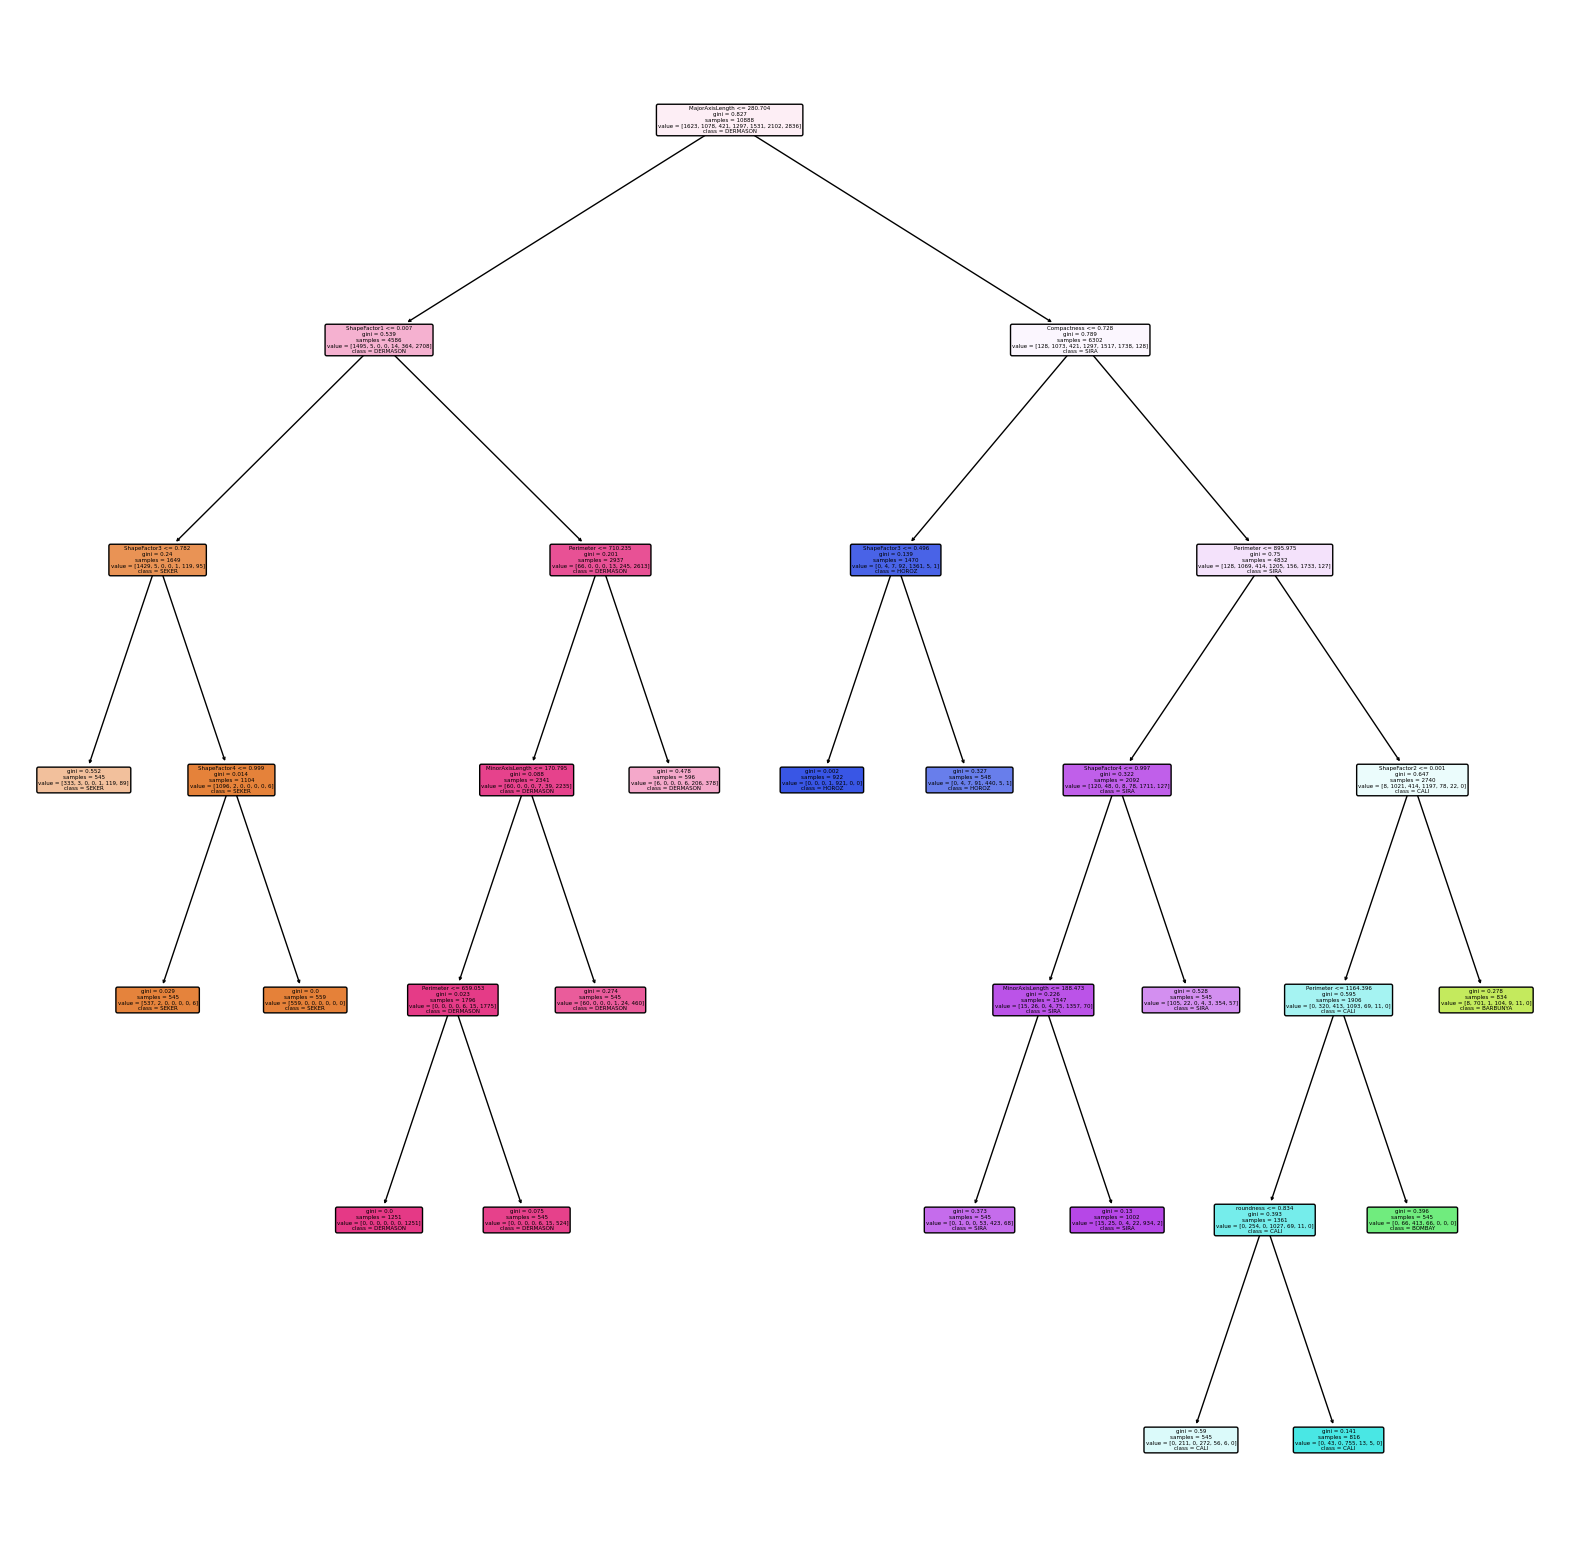

In [21]:
fig = plt.figure(figsize = (20, 20))
tree.plot_tree(
    dtc,
    feature_names = list(df.columns[:-2]),
    class_names = list(df.Class.unique()),
    rounded = True,
    filled = True);
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

#### graphviz

In [22]:
import graphviz # sudo apt install graphviz (also required by dtreeviz)
# pip install graphviz

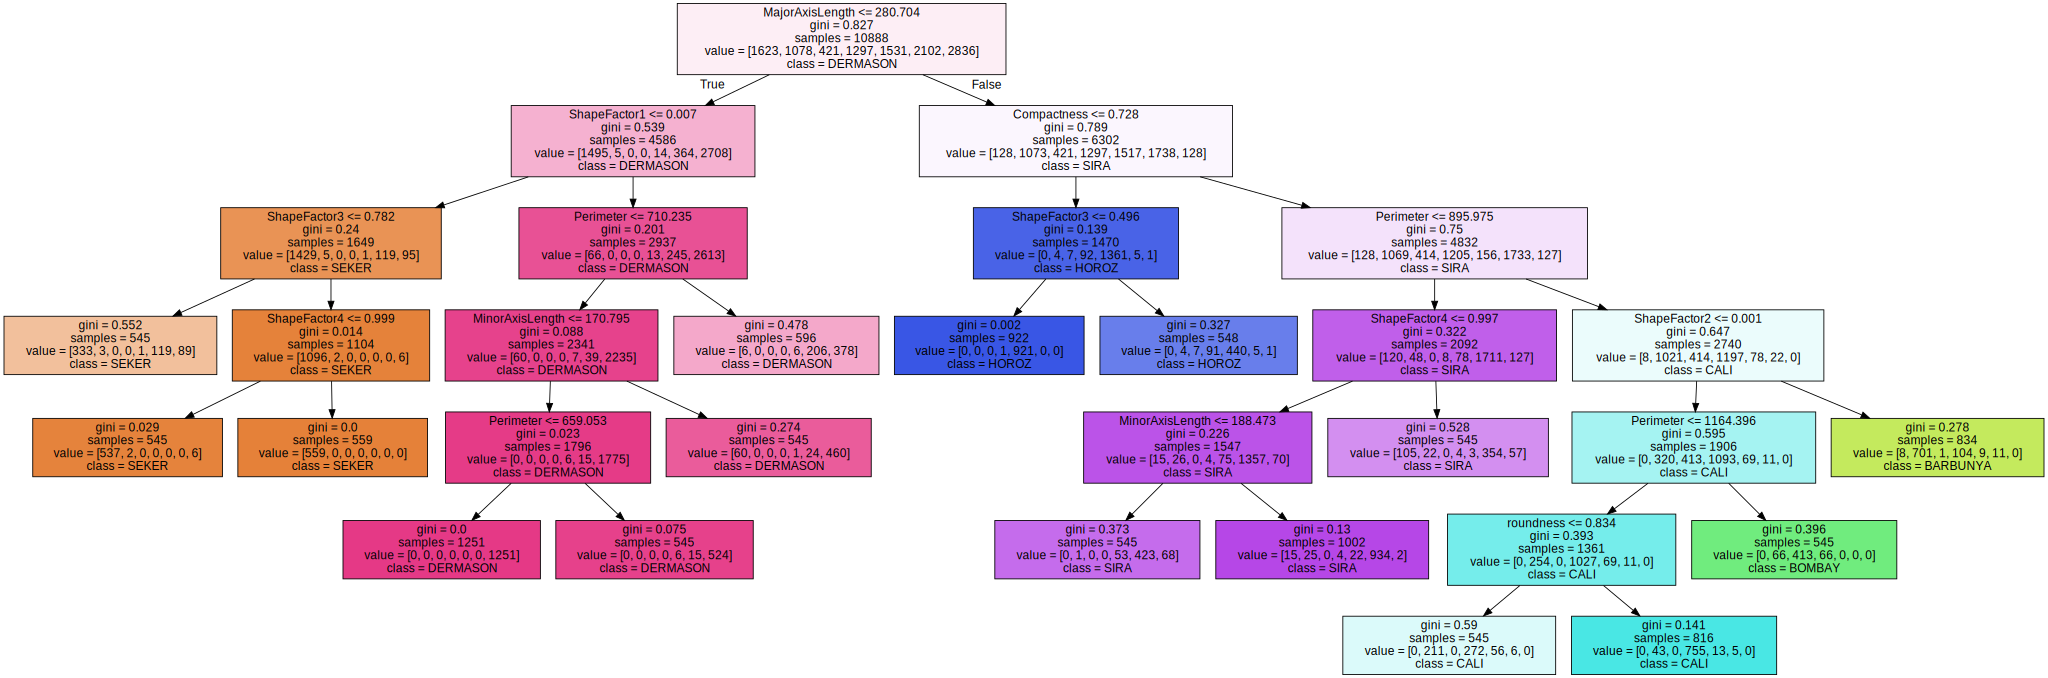

In [23]:
# export to dot format
dtc_dot = tree.export_graphviz(dtc,
            out_file = None, # give file pointer to save to file
            feature_names = list(df.columns[:-2]),  
            class_names = list(df.Class.unique()),
            filled = True)
# draw
graph = graphviz.Source(dtc_dot, format = "png")
graph

##### dTreeviz

In [24]:
import dtreeviz # pip install dtreeviz[all]
import warnings
warnings.simplefilter("ignore")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

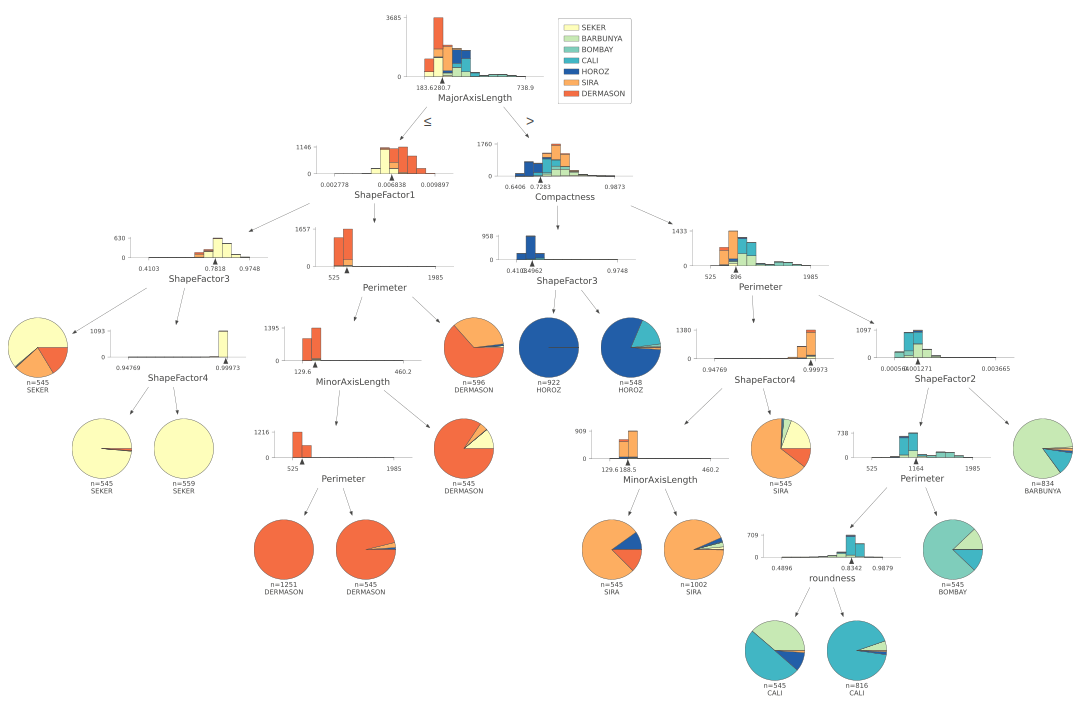

In [25]:
dtc_viz = dtreeviz.model(dtc, X_train = Xtrain, y_train = ytrain,
        feature_names = list(df.columns[:-2]),  
        class_names = list(df.Class.unique()),
    )
dtc_viz.view()